In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_29.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_244.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_135.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_200.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_124.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_94.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_89.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_270.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_238.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_68.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_

**importing libraries**

To begin with, we need to import several libraries to enable us to perform various tasks related to data visualization, image processing, and machine learning. 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image
from sklearn.model_selection import train_test_split

**Loading the Dataset:**

In [8]:
root="/kaggle/input/lemon-quality-dataset/lemon_dataset/"

In [9]:
categories=os.listdir(root)
categories.remove('.git')
categories

['empty_background', 'good_quality', 'bad_quality']

**Creating Image and Label Lists**

In [10]:
images = []
labels = []
for category in categories:
    directory = root + category + '/'
    for image_file in os.listdir(directory):
        images.append(directory + image_file)
        labels.append(category)


**Creating a DataFrame**

In [11]:
images = pd.Series(images, name="Image")
labels = pd.Series(labels, name="Quality")


In [12]:
data=pd.concat([images,labels], axis=1)
data.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
1,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
2,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
3,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
4,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background


****Shuffling the DataFrame****

In [13]:
data=data.sample(frac=1).reset_index(drop = True)
data.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,bad_quality
1,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
2,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
3,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
4,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality


**Displaying Random Images**

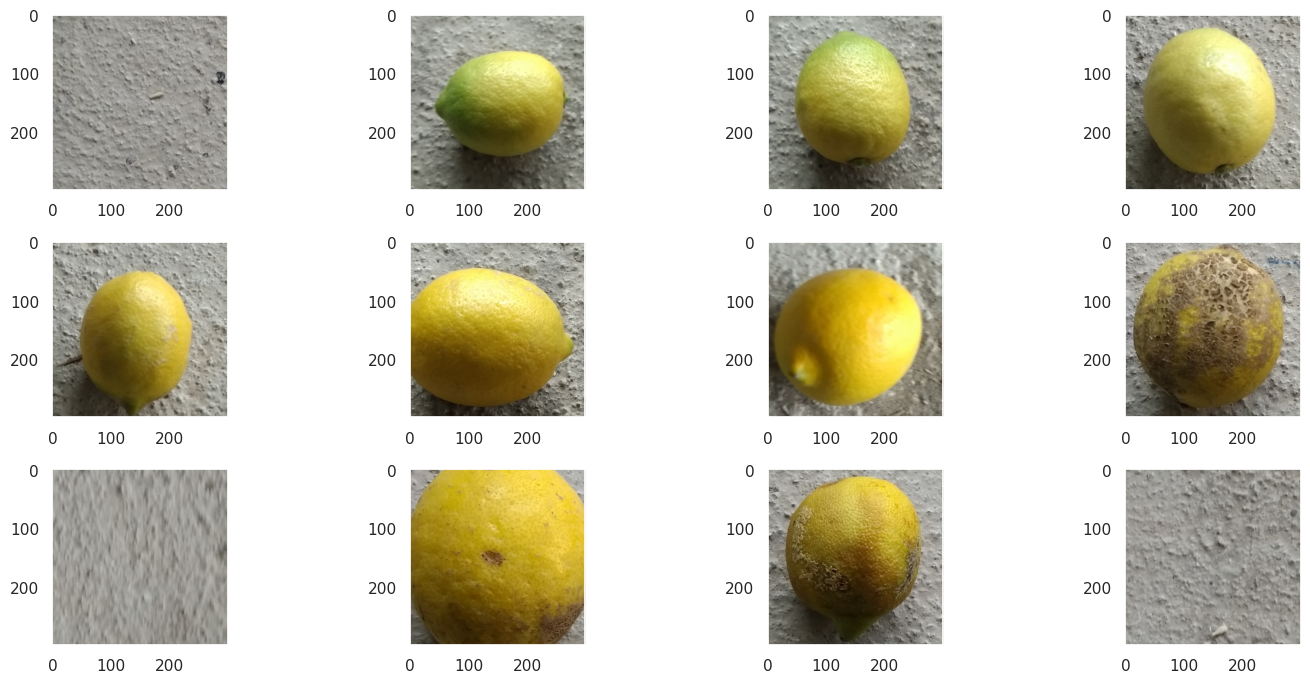

In [76]:
fig, axes = plt.subplots(3, 4, figsize=(15, 7))

for ax in axes.flat:
    i = np.random.randint(0, data.shape[0])
    ax.imshow(Image.open(data.loc[i, "Image"]))
    ax.grid(False)  
    
plt.tight_layout()
plt.show()

**Train-Test Split:**

In [16]:
dev, held_out =train_test_split(
    data, 
    train_size=0.9, 
    shuffle=True,
    random_state=42)

**Printing Shape Information:**

In [17]:
print(dev.shape)
print(held_out.shape)

(2275, 2)
(253, 2)


# Data Preprocessing and Image Data Generators

In [20]:
import keras

In [21]:
from keras.preprocessing import image

**Rescaling,Data Augmentation and rescaling**

In [22]:
# Rescaling and Data Augmentation
dev_generator = image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

# In this case, the generator performs rescaling (normalization) on the image.
# Each pixel value is divided by 255 to obtain values in the range [0, 1].
held_generator = image.ImageDataGenerator(rescale=1./255)

**Flow from DataFrame:**

In [23]:
train_images = dev_generator.flow_from_dataframe(
    dataframe=dev,  # Make sure to provide the correct DataFrame
    x_col='Image',  # Update to the correct column name for images
    y_col='Quality',  # Update to the correct column name for labels
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1820 validated image filenames belonging to 3 classes.


In [24]:
val_images = dev_generator.flow_from_dataframe(
    dataframe=dev,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 455 validated image filenames belonging to 3 classes.


**Flow from DataFrame for Testing**

In [25]:
held_images = held_generator.flow_from_dataframe(
    dataframe=held_out,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 253 validated image filenames belonging to 3 classes.


**class indices**

In [26]:
labels = train_images.class_indices
labels

{'bad_quality': 0, 'empty_background': 1, 'good_quality': 2}

# VGG16 Fine-tuning

**This code demonstrates how to perform fine-tuning using the VGG16 model. The VGG16 model is a deep convolutional neural network that has been pre-trained on the ImageNet dataset. Fine-tuning involves taking the pre-trained model and adapting it to a new task or dataset by training the top layers while keeping the lower layers frozen.**

In [34]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop


1. Load the pre-trained VGG16 model:
   - The `VGG16` class from `keras.applications` is used to load the pre-trained VGG16 model without the top layer.
   - The `weights` parameter is set to `'imagenet'` to load the weights trained on ImageNet.
   - The `include_top` parameter is set to `False` to exclude the fully connected layers at the top of the network.
   - The `input_shape` parameter is set to `(150, 150, 3)` to match the expected input size.


In [35]:
# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


2. Freeze the layers in the base model:
   - The layers in the base model are iterated through, and their `trainable` attribute is set to `False`. This freezes the weights of the layers so that they are not updated during training.

3. Add custom top layers:
   - A series of fully connected and dropout layers are added on top of the base model to learn task-specific features.
   - The `Flatten` layer is used to flatten the output of the base model.
   - Two `Dense` layers with 4096 units and ReLU activation are added, along with `Dropout` layers with a dropout rate of 0.5 to prevent overfitting.
   - The final `Dense` layer with 3 units and softmax activation is added to generate the predictions for the three classes.

4. Create the fine-tuned model:
   - The `Model` class from `keras.models` is used to create the fine-tuned model, specifying the inputs and outputs.
   - The input is set to the input of the base model, and the output is set to the predictions generated by the custom top layers.


In [36]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)


5. Compile the model:
   - The model is compiled using the `RMSprop` optimizer with a learning rate of 0.0001.
   - The loss function is set to `'categorical_crossentropy'`, and the accuracy metric is used for evaluation.

In [37]:
# Define optimizer
optimizer = RMSprop(learning_rate=0.0001)
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


displaying the model summary()

In [38]:
# Print model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

6. Train the model:
   - The model is trained using the `fit` method.
   - The training data (`train_images`) and validation data (`val_images`) are provided.
   - The number of epochs is set to 30, and the defined callbacks (`callbacks_list`) are used for early stopping and learning rate reduction.


In [40]:
# Train the model
history = model.fit(train_images, validation_data=val_images,epochs=50)

Epoch 1/50
57/57 [==============================] - 19s 334ms/step - loss: 0.1412 - accuracy: 0.9484 - val_loss: 0.0961 - val_accuracy: 0.9648
Epoch 2/50
57/57 [==============================] - 18s 318ms/step - loss: 0.1392 - accuracy: 0.9538 - val_loss: 0.1721 - val_accuracy: 0.9209
Epoch 3/50
57/57 [==============================] - 19s 326ms/step - loss: 0.1628 - accuracy: 0.9467 - val_loss: 0.0891 - val_accuracy: 0.9626
Epoch 4/50
57/57 [==============================] - 17s 305ms/step - loss: 0.1099 - accuracy: 0.9599 - val_loss: 0.0927 - val_accuracy: 0.9582
Epoch 5/50
57/57 [==============================] - 18s 317ms/step - loss: 0.1362 - accuracy: 0.9588 - val_loss: 0.3018 - val_accuracy: 0.9121
Epoch 6/50
57/57 [==============================] - 18s 317ms/step - loss: 0.1366 - accuracy: 0.9604 - val_loss: 0.0951 - val_accuracy: 0.9560
Epoch 7/50
57/57 [==============================] - 17s 304ms/step - loss: 0.1389 - accuracy: 0.9571 - val_loss: 0.1156 - val_accuracy: 0.9560

# Training and Validation Metrics Visualization

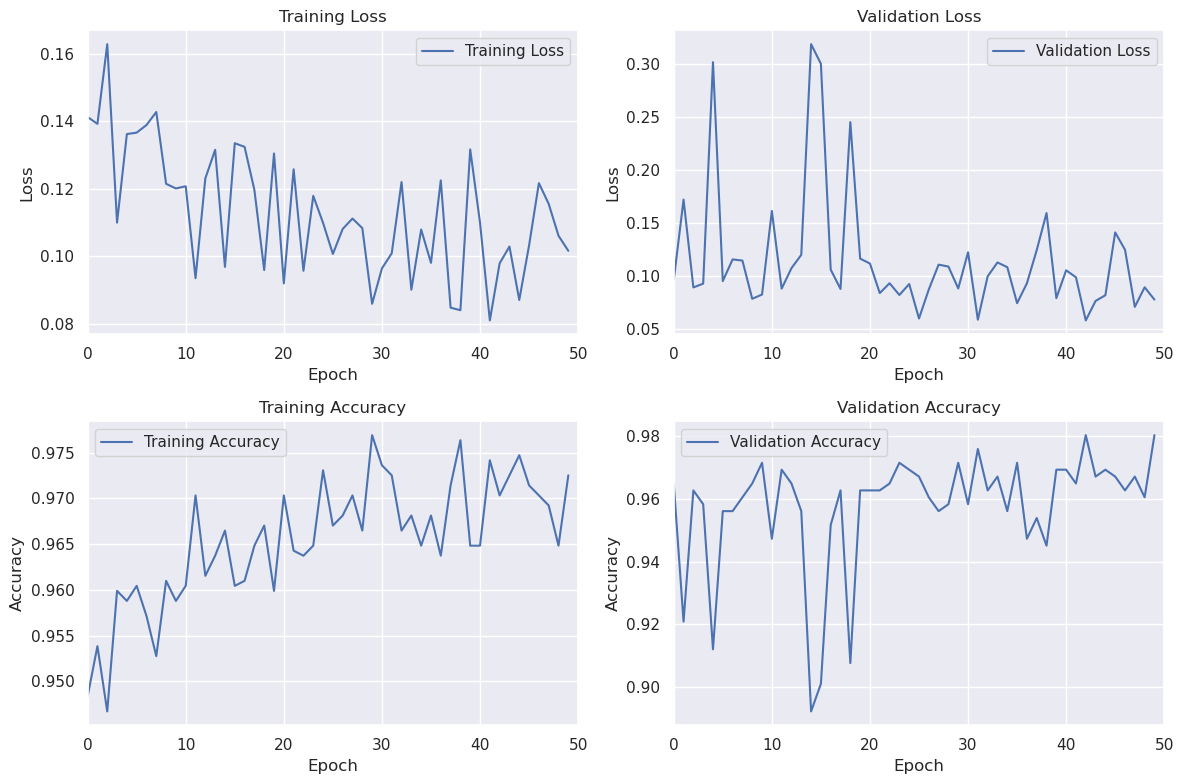

In [51]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot training loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_xlim([0, 50])  # Set x-axis limits

# Plot validation loss
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_xlim([0, 50])  # Set x-axis limits

# Plot training accuracy
axes[1, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].set_xlim([0, 50])  # Set x-axis limits

# Plot validation accuracy
axes[1, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].set_xlim([0, 50])  # Set x-axis limits

plt.tight_layout()
plt.show()


**Model Prediction and Evaluation**

In [52]:
prediction=model.predict(held_images)

8/8 [==============================] - 1s 79ms/step


In [53]:
prediction=np.argmax(prediction, axis=1)
prediction.shape

(253,)

In [54]:
labels = train_images.class_indices
labels = {v: k for k, v in labels.items()}

In [55]:
y_prediction = [labels.get(k) for k in prediction]
y_test = held_out["Quality"].values

**Accuracy Evaluation**

In [56]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_prediction))

                  precision    recall  f1-score   support

     bad_quality       0.99      0.97      0.98        89
empty_background       1.00      1.00      1.00        43
    good_quality       0.98      0.99      0.98       121

        accuracy                           0.98       253
       macro avg       0.99      0.99      0.99       253
    weighted avg       0.98      0.98      0.98       253



In [57]:
accuracy_score(y_prediction, y_test)

0.9841897233201581

**Confusion Matrix**

In [58]:
from sklearn.metrics import confusion_matrix

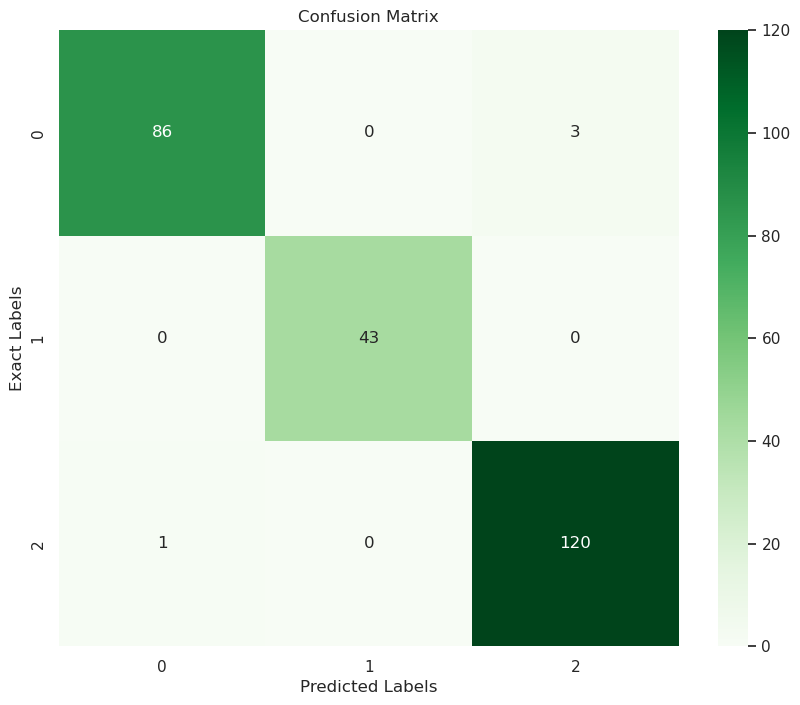

In [59]:
cm = confusion_matrix(y_test, y_prediction)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Exact Labels")
plt.show()

# Visualizing Predicted Labels on Random Images

In [60]:
held_out.reset_index(drop=True, inplace=True)
held_out.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
1,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
2,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
3,/kaggle/input/lemon-quality-dataset/lemon_data...,bad_quality
4,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality


In [61]:
random_index = np.random.randint(0, held_out.shape[0])
image_path = held_out.loc[random_index, "Image"]
predicted_label = y_prediction[random_index]

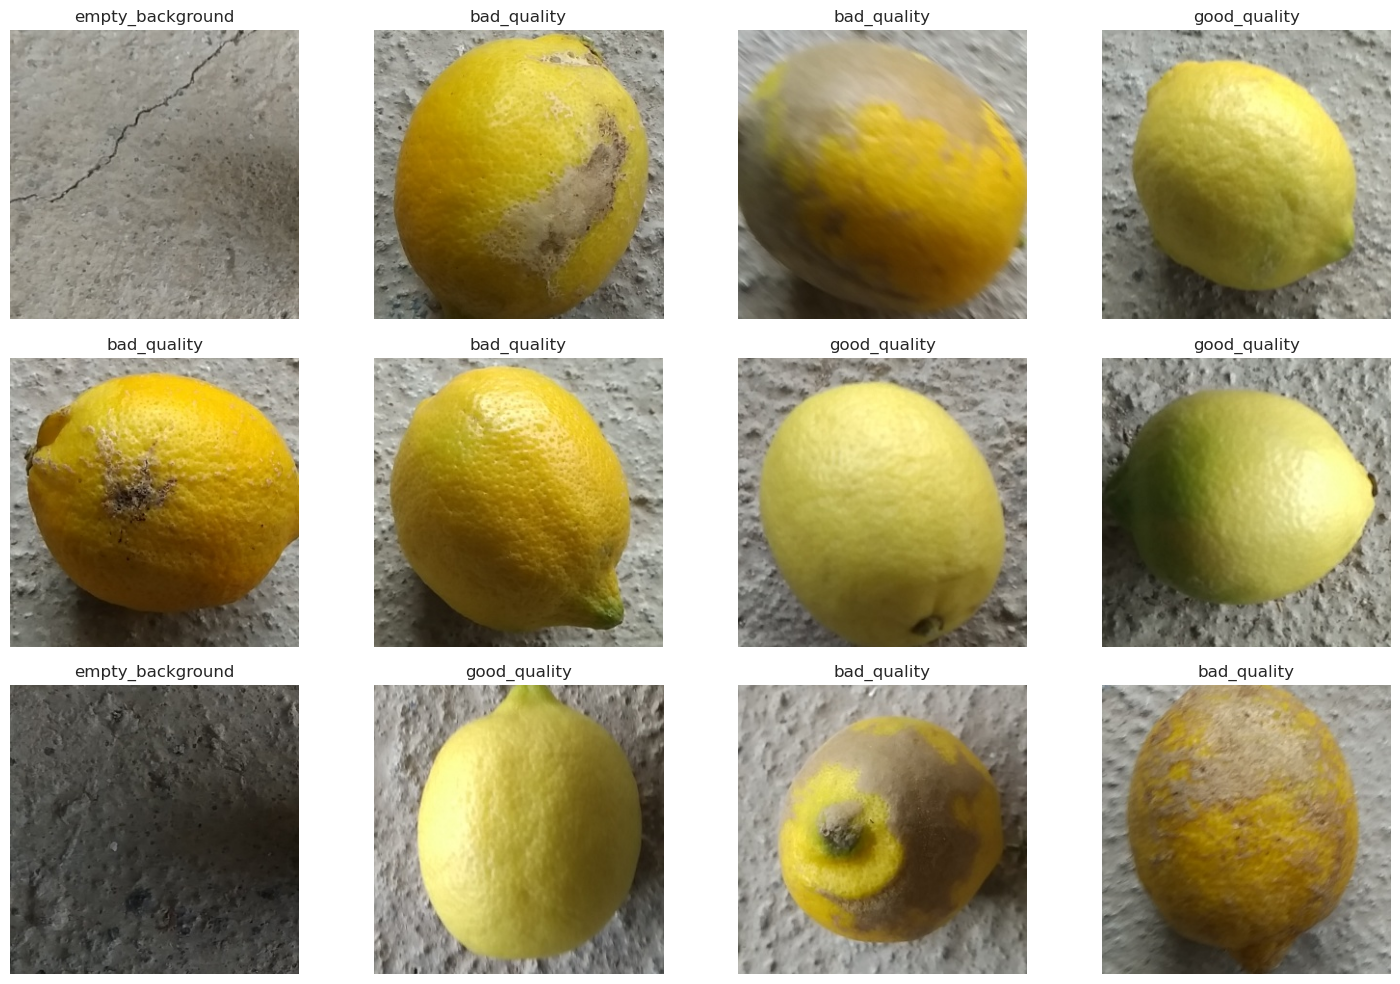

In [74]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Iterate over the axes and randomly select 12 indices
for i, ax in enumerate(axes.flatten()):
    random_index = np.random.randint(0, held_out.shape[0])
    image_path = held_out.loc[random_index, "Image"]
    predicted_label = y_prediction[random_index]

    # Plot the image on the current subplot
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(predicted_label)

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()


In [77]:
import tensorflow as tf

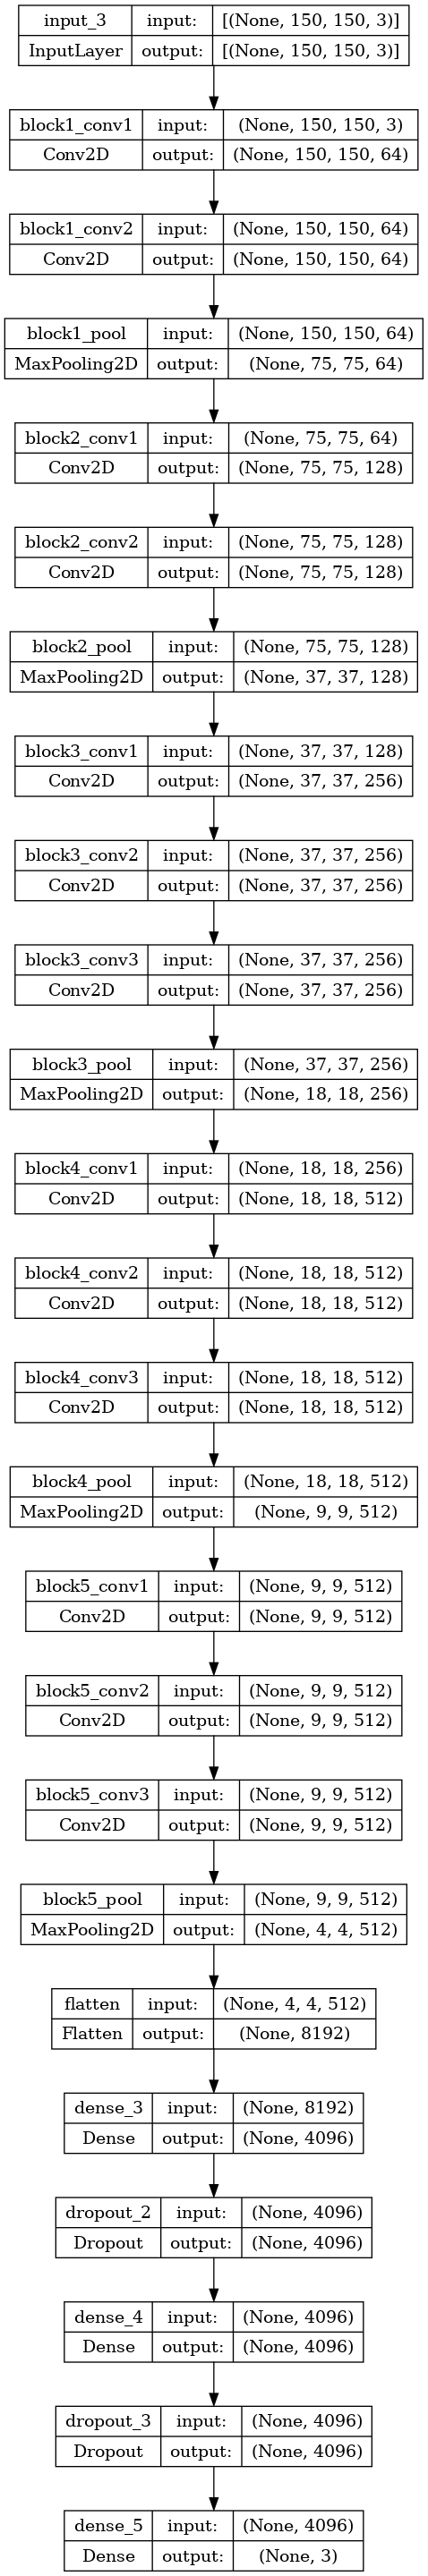

In [78]:
tf.keras.utils.plot_model(model, to_file='complex_model.png', show_shapes=True)